# A Brief Note on Monte Carlo Integration

C. Schiff - 8/23/20201

Last Revised - 11/26/2021

The aim of this note is to demontrate the basic functionality of Monte Carlo integration.  

Suppose we have an integral $$I = \int_{x_{min}}^{x_{max}} dx f(x)$$

An adequate approximation to this integral is

$$ I \approx \frac{x_{max} - x_{min}}{N} \sum_{i} f(x_i) $$

where the $x_i$ are chosen randomly within the interval $[x_{min},x_{max}]$ and $N$ is the number of trials.  (see:  https://math.stackexchange.com/questions/2217922/understanding-monte-carlo-and-importance-sampling). 

Let's see this in action for a couple examples.

Usual import stuff

In [69]:
import numpy  as np
import pandas as pd
import scipy  as sp

import matplotlib.pyplot as plt
import scipy.integrate   as integrate
import scipy.stats       as stats

## Define a typical polynomial such as

$$3.4 x^3 - 5.9 x^2 + 0.3 x - 15.2$$.

In [2]:
def f(x):
    return 3.4*x**3 - 5.9*x**2 + 0.3*x - 15.2

The anti-derivative of this hideous polynomial is 

$$ \frac{3.4}{4} x^4 - \frac{5.9}{3} x^3 + \frac{0.3}{2} x^2 - 15.2 x$$

In [3]:
def F(x):
    return (3.4/4)*x**4 - (5.9/3)*x**3 + (0.3/2)*x**2 - 15.2*x

In [4]:
x_min = -2
x_max = 3.5
dx    = 0.1
x = np.linspace(x_min,x_max,100)
y = f(x)

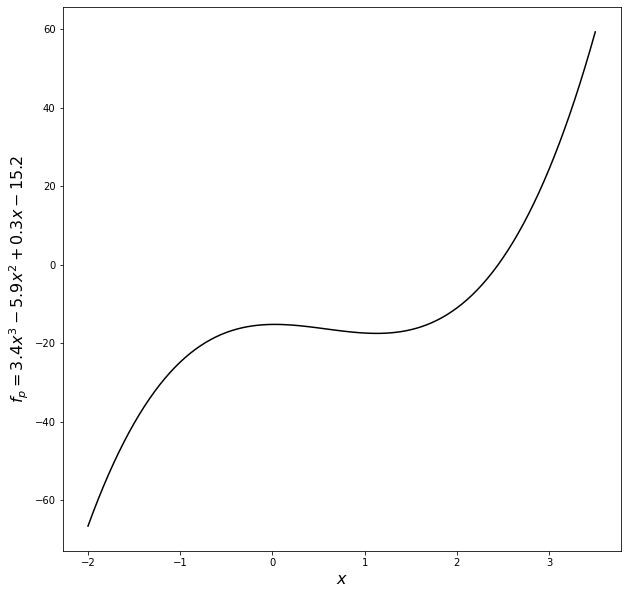

In [11]:
plt.figure(figsize=(10,10))
plt.plot(x,y,'k-')
plt.xlabel('$x$',fontsize=16)
plt.ylabel('$f_p = 3.4 x^3 - 5.9 x^2 + 0.3 x - 15.2$',fontsize=16)
#plt.savefig('f_p_look.png')

In [52]:
rand_x      = x_min + (x_max - x_min)*np.random.random(size=100_000)
rand_y      = f(rand_x)
I_poly_est  = (x_max - x_min)*np.average(rand_y)

In [49]:
integrate.quad(f,x_min,x_max)

(-68.46354166666667, 1.3517157778535473e-12)

In [50]:
I_poly_true = F(x_max)-F(x_min)

In [51]:
print('true: ',I_poly_true,'\t','estimate: ',I_poly_est)
print('relative error:  ', np.abs(I_poly_true-I_poly_est)/np.abs(I_poly_true))

true:  -68.46354166666669 	 estimate:  -68.41351240649676
relative error:   0.0007307430926302718


## Now define a fairly nasty function 

$$ 4 \sin \left( 2 \pi e^{\cos x^2} \right) $$

In [18]:
def f_nasty(x):
    return 4*np.sin(2*np.pi*np.exp(np.cos(np.power(x,2))))

In [19]:
x_min = -2
x_max = 3.5
x_nasty = np.linspace(x_min,x_max,1000)
y_nasty = f_nasty(x_nasty)

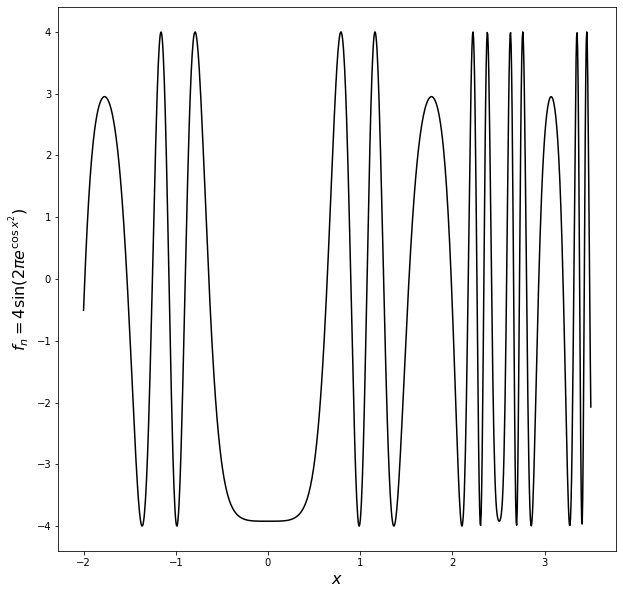

In [36]:
plt.figure(figsize=(10,10))
plt.plot(x_nasty,y_nasty,'k-')
plt.xlabel('$x$',fontsize = 16)
plt.ylabel('$f_n = 4 \sin ( 2 \pi e^{\cos x^2} )$',fontsize = 16)
#plt.savefig('f_n_look.png')

In [37]:
rand_x_nasty = x_min + (x_max - x_min)*np.random.rand(100_000)
rand_y_nasty = f_nasty(rand_x_nasty)

In [38]:
I_nasty_est = (x_max - x_min)*np.mean(rand_y_nasty)

In [39]:
print(I_nasty_est)

-2.8020549889975164


Appeal to scipy's quad function to get the 'truth' and find that it is almost the same

In [44]:
I_nasty_quad = integrate.quad(f_nasty,x_min,x_max)

In [46]:
print('I_nasty_est',I_nasty_est,'I_nasty_quad',I_nasty_quad[0])
print('relative error:  ',np.abs(I_nasty_est-I_nasty_quad[0])/np.abs(I_nasty_quad[0]))

I_nasty_est -2.8020549889975164 I_nasty_quad -2.824748541066965
relative error:   0.008033830884244605


## Empircal Error Analysis

In [122]:
x_min = -2
x_max = 3.5
Ns = [100,1_000,5_000,10_000,50_000,100_000,500_000,1_000_000,10_000_000,100_000_000]
df = pd.DataFrame()
for N in Ns:
    U     = np.random.random(size=N)
    X     = x_min + (x_max - x_min)*U
    F     = f(X)
    I_est = (x_max - x_min)*np.mean(F)
    row   = {'N':N,'I_est':I_est,'Err':np.abs(I_poly_true-I_est)}
    df    = df.append(row,ignore_index=True)

In [143]:
df['Err']

0    28.405712
1     0.734030
2     1.497241
3     1.581672
4     0.742398
5     0.136062
6     0.283996
7     0.031013
8     0.085116
9     0.004519
Name: Err, dtype: float64

In [124]:
fit = sp.stats.linregress(np.log10(df['N']),np.log10(df['Err']))
model = 10**(fit.intercept)*Ns**(fit.slope)
print(fit)

LinregressResult(slope=-0.5291884088159343, intercept=2.1209302424479732, rvalue=-0.9237114743570284, pvalue=0.0001350490633506258, stderr=0.07759407666789961, intercept_stderr=0.4041161472220047)


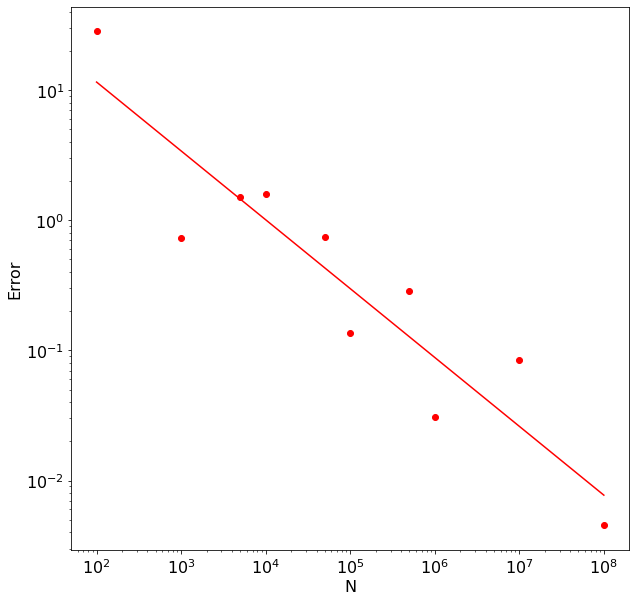

In [146]:
plt.figure(figsize=(10,10))
plt.loglog(df['N'],df['Err'],'ro')
plt.loglog(df['N'],model,'r-')
plt.xlabel('N',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.savefig('d:/github/BlogWyrm/Posts/2021/Nov/Aristotle2Digital/MC_error.png')

In [130]:
def f_circ(x):
    return 4.0*np.sqrt(1.0-x**2)

In [158]:
N       = 100_000
num_est = 10
df_circ = pd.DataFrame()
for i in range(num_est):
    U       = np.random.random(size=N)
    C       = f_circ(U)
    I_est   = np.mean(C)
    row     = {'I_est':I_est,'error':np.abs(np.pi-I_est),'sig_est':np.std(C)}
    df_circ = df_circ.append(row,ignore_index=True)    

In [159]:
df_circ

,I_est,error,sig_est
0,3.143074,0.001481,0.892373
1,3.146796,0.005203,0.888127
2,3.142626,0.001034,0.895669
3,3.139204,0.002389,0.893454
4,3.145947,0.004355,0.891186
5,3.142209,0.000616,0.892600
6,3.137025,0.004568,0.896624
7,3.136014,0.005578,0.895747
8,3.140397,0.001196,0.892305
9,3.140693,0.000900,0.892604


In [190]:
print('The mean of the means is:', np.mean(df_circ['I_est']))
print('The std of the means is: ', np.std(df_circ['I_est']))
print('The mean of the stds is: ', np.mean(df_circ['sig_est']))
print('The mean error is:       ', np.mean(df_circ['error']),np.pi - np.mean(df_circ['I_est']))

The mean of the means is: 3.1413985717765454
The std of the means is:  0.003304946237283195
The mean of the stds is:  0.8930688485193065
The mean error is:        0.0027319130714524853 0.00019408181324775953


In [194]:
0.8930688/0.003304946237283195

270.2218843759892

In [160]:
N        = 100_000
num_est  = 1000
df_circ2 = pd.DataFrame()
for i in range(num_est):
    U        = np.random.random(size=N)
    C        = f_circ(U)
    I_est    = np.mean(C)
    row      = {'I_est':I_est,'error':np.abs(np.pi-I_est),'sig_est':np.std(C)}
    df_circ2 = df_circ2.append(row,ignore_index=True)    

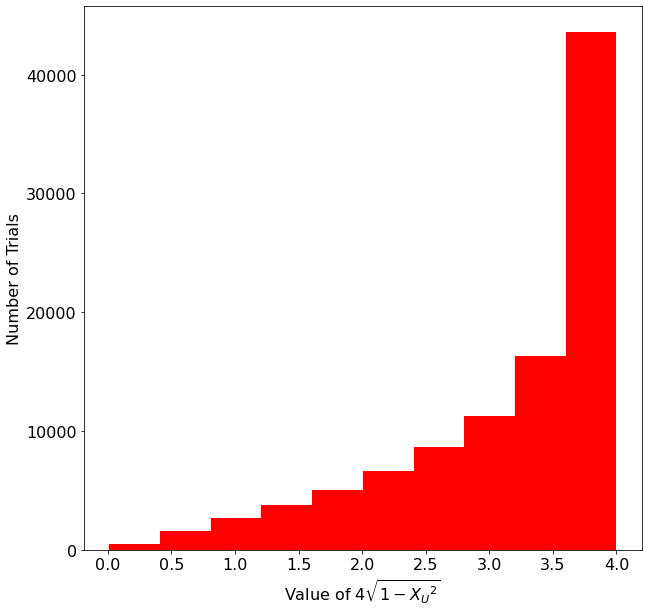

In [173]:
plt.figure(figsize=(10,10))
plt.hist(C,color='r')
plt.xlabel('Value of $4 \sqrt{1-{X_U}^2}$',fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Number of Trials',fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('d:/github/BlogWyrm/Posts/2021/Nov/Aristotle2Digital/Single_Meas_distribution.png')

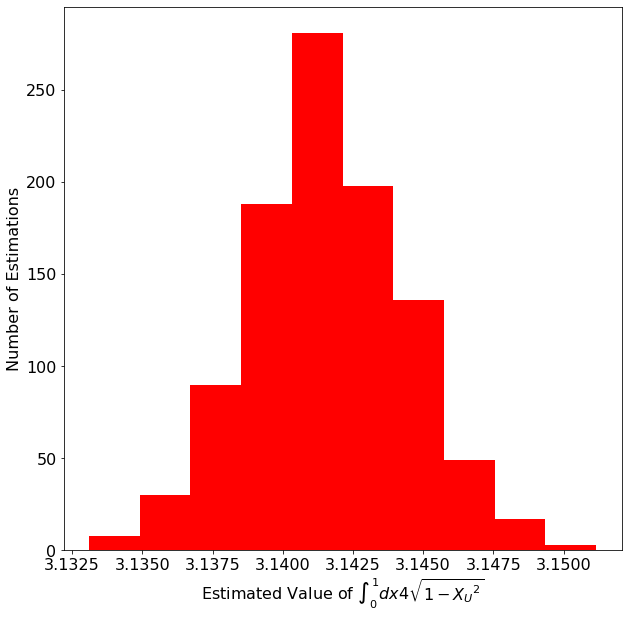

In [172]:
plt.figure(figsize=(10,10))
plt.hist(df_circ2['I_est'],color='r')
plt.xlabel('Estimated Value of $\int_0^1 dx 4 \sqrt{1-{X_U}^2}$',fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Number of Estimations',fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('d:/github/BlogWyrm/Posts/2021/Nov/Aristotle2Digital/Iest_distribution.png')

In [175]:
(-0.9237114743570284)**2

0.8532428878588351